<a href="https://colab.research.google.com/github/Code-Trees/CNN/blob/master/Mnist_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#In this Notebook I tried to build a Network which is optimisez to use less parameters and give best performance .
#The concept and Techniques are taken from Resnet and Vgg Net learnings .


In [2]:
#importing for better interactivity of shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
#Importing Needed Modules

"""Pytorch have Major 4 Classes:
    1> Autograd:Provide Automatic differentation
    2> nn -> 2.1: nn.Moduls : Used for model arch building
             2.2: nn.functional : Used for model arch building
    3> Opti: Provides Different kinds of Optimizers 
    4> utils: Provides Utils for models, dataloaders,  etc
   Also 
   torchvision: This  module is to  provide  different datasets for model trainning 
   and data : transforms etc .
"""

'Pytorch have Major 4 Classes:\n    1> Autograd:Provide Automatic differentation\n    2> nn -> 2.1: nn.Moduls : Used for model arch building\n             2.2: nn.functional : Used for model arch building\n    3> Opti: Provides Different kinds of Optimizers \n    4> utils: Provides Utils for models, dataloaders,  etc\n   Also \n   torchvision: This  module is to  provide  different datasets for model trainning \n   and data : transforms etc .\n'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.nn.functional as F
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader

In [6]:
from torchvision import transforms,datasets
import matplotlib.pyplot as plt

In [7]:
#This module i have designed to Calculate the receptive field of a CNN model.
#Please read the documentation for mode details
#https://pypi.org/project/rf-calc/
 
!pip install rf_calc
from rf_calc import receptive_field

In [8]:
import numpy as np
from torchsummary import summary

In [9]:
# Downloading the data from  as train and test

train = datasets.MNIST(root = './',train = True,download=True,transform=transforms.Compose([transforms.ToTensor(),
                                                                                            transforms.Normalize((0.13066062331199646,),(0.30810776352882385,)),
                                                                                            transforms.RandomRotation((-7,7) ,fill = 0.13066062331199646)
                                                                                            ])) 
test = datasets.MNIST(root = './',train = False,download=True,transform=transforms.Compose([transforms.ToTensor(),
                                                                                            transforms.Normalize((0.13066062331199646,),(0.30810776352882385,))                                                                                            
                                                                                            ])) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
#Checking the data 
next(iter(train))[0].shape
im1 = next(iter(train))[0].reshape(-1,28)

torch.Size([1, 28, 28])

Text(0.5, 1.0, '5')

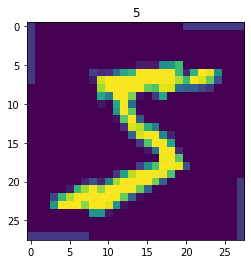

In [11]:
_ = plt.imshow(im1)
plt.title(next(iter(train))[1])

In [12]:
# I want o Go with the batch size 64 here . Because of the below reseach paper:
#It is a subjective matter (depends on the kind of problem we are solving )
batch_size = 64

In [13]:
#Checking if cuda (GPU ) is availabe them we want to add 4 workers to it
args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}

In [14]:
#Creating Dataloader loader 
train_loader = DataLoader(train,batch_size=batch_size,shuffle = True,**args)
test_loader = DataLoader(test,batch_size=batch_size,**args)

In [15]:
### EDA of DATA to find mean and std for normalization

In [16]:
f'Mean: {np.array(train.train_data/255).mean()} Std: {np.array(train.train_data/255).std()}'


'Mean: 0.13066062331199646 Std: 0.30810776352882385'

In [17]:
#Hear we Go to build a model 

In [18]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Mnist_net(nn.Module):
    def __init__(self):
        super(Mnist_net,self).__init__()
        self.drop_val =0.1

        self.conv_block1 = nn.Sequential(
                    nn.Conv2d(in_channels = 1,out_channels = 4,kernel_size = (3,3),stride = 1,padding = 1,bias = False ),
                    nn.ReLU( ) ,
                    nn.BatchNorm2d(num_features = 4),
                    nn.Dropout(self.drop_val)
        )

        self.conv_block1_1 = nn.Sequential(
                    nn.Conv2d(in_channels = 4,out_channels = 8,kernel_size =(3,3),stride = 1,padding = 0,bias = False ),
                    nn.ReLU( ) ,
                    nn.BatchNorm2d(num_features = 8),
                    nn.Dropout(self.drop_val)
        )

        self.conv_block2 = nn.Sequential(
                    nn.Conv2d(in_channels = 8,out_channels =16 ,kernel_size = (3,3),stride = 1,padding = 0,bias = False ),
                    nn.ReLU( ) ,
                    nn.BatchNorm2d(num_features = 16),
                    nn.Dropout(self.drop_val)
        )

        self.conv_block3 = nn.Sequential(
                    nn.Conv2d(in_channels = 16,out_channels =8 ,kernel_size = (1,1) ,stride = 1,padding = 0,bias = False ),
                    nn.ReLU( ) ,
                    nn.BatchNorm2d(num_features = 8),
                    nn.Dropout(self.drop_val)
        )


        self.Pooling1 = nn.MaxPool2d(kernel_size = 2,stride = 2 )


        self.conv_block4 = nn.Sequential(
                    nn.Conv2d(in_channels = 8,out_channels =10 ,kernel_size = 3,stride = 1,padding = 0,bias = False ),
                    nn.ReLU( ) ,
                    nn.BatchNorm2d(num_features = 10),
                    nn.Dropout(self.drop_val)
        )

        self.conv_block5= nn.Sequential(
                    nn.Conv2d(in_channels = 10,out_channels =10 ,kernel_size = 3,stride = 1,padding = 0,bias = False ),
                    nn.ReLU( ) ,
                    nn.BatchNorm2d(num_features = 10),
                    nn.Dropout(self.drop_val)
        )

        self.conv_block6 = nn.Sequential(
                    nn.Conv2d(in_channels = 10,out_channels =15 ,kernel_size = 3,stride = 1,padding = 0,bias = False ),
                    # nn.ReLU( ) ,
                    # nn.BatchNorm2d(num_features = 18),
                    # nn.Dropout(self.drop_val)
        )

        # self.Pooling2 = nn.MaxPool2d(kernel_size = 2,stride = 2 )
        self.gap = nn.AvgPool2d(kernel_size=5)
        self.fc1 = nn.Linear(in_features = 15,out_features = 10)

        # self.conv_block7 = nn.Sequential(
        #             nn.Conv2d(in_channels = 18,out_channels =20 ,kernel_size = 3,stride = 1,padding = 0,bias = False ),
        #             nn.ReLU( ) ,
        #             nn.BatchNorm2d(num_features = 20),
        #             nn.Dropout(self.drop_val)
        # )

        # self.conv_block8 = nn.Sequential(
        # nn.Conv2d(in_channels = 20  ,out_channels =10 ,kernel_size = 3,stride = 1,padding = 0,bias = False )
        # )


    def forward(self,x):
        x = self.conv_block1(x) #1
        x = self.conv_block1_1(x)
        x = self.conv_block2(x) #2
        x = self.conv_block3(x) #3
        x = self.Pooling1(x) #
        x = self.conv_block4(x) #4
        x = self.conv_block5(x) #5
        x = self.conv_block6(x) #6
        # x = self.Pooling2(x)
        # x = self.conv_block7(x) #7
        # x = self.conv_block8(x)
        x = self.gap(x)
        x =x.view(-1,15)
        x = self.fc1(x)

        x=f.log_softmax(x)
        return x


In [19]:
# tried those below models aswell ( But just to get the stracture ready)

In [20]:
# dropout_value = 0.03
# class Mnist_net(nn.Module):
#     def __init__(self):
#         super(Mnist_net, self).__init__()
#         # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(10),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # input_size = 28 output_size = 26 receptive_field = 3

#         # CONVOLUTION BLOCK 1
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(10),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # input_size = 26 output_size = 24 receptive_field = 5
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(15),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # input_size = 24 output_size = 22 receptive_field = 7

#         # TRANSITION BLOCK 1
#         self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             nn.BatchNorm2d(10),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # input_size = 11 output_size = 11 receptive_field = 9

#         # CONVOLUTION BLOCK 2
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(10),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # input_size = 11 output_size = 9 receptive_field = 13
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(10),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # input_size = 9 output_size = 7 receptive_field = 17
#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(10),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # input_size = 7 output_size = 5 receptive_field = 21
#         # OUTPUT BLOCK
#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
#         ) # input_size = 5 output_size = 1  receptive_field = 29
        

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.convblock3(x)
#         x = self.pool1(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         x = self.convblock7(x)
#         x = self.convblock8(x)
        
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)

In [21]:
# from torch.nn.modules.batchnorm import BatchNorm2d
# class Mnist_net(nn.Module):
#     def __init__(self):
#         super(Mnist_net,self).__init__()
#         self.drop_val =0.001
#         self.conv_block1 = nn.Sequential(
#             nn.Conv2d(in_channels = 1,out_channels = 8,kernel_size = 3,stride = 1,padding = 1,bias = False ),
#             nn.ReLU( ) ,
#             nn.BatchNorm2d(num_features = 8),
#             nn.Dropout(self.drop_val)
#         )

#         self.conv_block2 = nn.Sequential(
#             nn.Conv2d(in_channels = 8,out_channels =10 ,kernel_size = 3,stride = 1,padding = 1,bias = False ),
#             nn.ReLU( ) ,
#             nn.BatchNorm2d(num_features = 10),
#             nn.Dropout(self.drop_val)
#         )
        
#         self.conv_block3 = nn.Sequential(
#             nn.Conv2d(in_channels = 10,out_channels =12 ,kernel_size = 3,stride = 1,padding = 1,bias = False ),
#             nn.ReLU( ) ,
#             nn.BatchNorm2d(num_features = 12),
#             nn.Dropout(self.drop_val)
#         )


#         self.Pooling1 = nn.MaxPool2d(kernel_size = 2,stride = 2 )

#         self.conv_block4 = nn.Sequential(
#             nn.Conv2d(in_channels = 12,out_channels =16 ,kernel_size = 1,stride = 1,padding = 0,bias = False ),
#             nn.ReLU( ) ,
#             nn.BatchNorm2d(num_features = 16),
#             nn.Dropout(self.drop_val)
#         )

#         self.conv_block5= nn.Sequential(
#             nn.Conv2d(in_channels = 16,out_channels =18 ,kernel_size = 3,stride = 1,padding = 0,bias = False ),
#             nn.ReLU( ) ,
#             nn.BatchNorm2d(num_features = 18),
#             nn.Dropout(self.drop_val)
#         )

#         self.conv_block6 = nn.Sequential(
#             nn.Conv2d(in_channels = 18,out_channels =20 ,kernel_size = 3,stride = 1,padding = 0,bias = False ),
#             nn.ReLU( ) ,
#             nn.BatchNorm2d(num_features = 20),
#             nn.Dropout(self.drop_val)
#         )

#         self.Pooling2 = nn.MaxPool2d(kernel_size = 2,stride = 2 )

#         self.conv_block7 = nn.Sequential(
#             nn.Conv2d(in_channels = 20,out_channels =24 ,kernel_size = 3,stride = 1,padding = 0,bias = False ),
#             nn.ReLU( ) ,
#             nn.BatchNorm2d(num_features = 24),
#             nn.Dropout(self.drop_val)
#         )
#         self.conv_block8 = nn.Sequential(
#             nn.Conv2d(in_channels = 24  ,out_channels =10 ,kernel_size = 3,stride = 1,padding = 0,bias = False )
#         )

#         # self.Gap = nn.AvgPool2d(kernel_size = 3,stride = 1)

#     def forward(self,x):
#         x = self.conv_block1(x) #1
#         x = self.conv_block2(x) #2
#         x = self.conv_block3(x) #3
#         x = self.Pooling1(x) #
#         x = self.conv_block4(x) #4
#         x = self.conv_block5(x) #5
#         x = self.conv_block6(x) #6
#         x = self.Pooling2(x)
#         x = self.conv_block7(x) #7
#         x = self.conv_block8(x)
#         # x = self.Gap(x)
#         x =x.view(-1,10)
#         x=f.log_softmax(x)
#         return x


In [22]:
#Checking Device 
device = "cuda" if torch.cuda.is_available() else "cpu"
print (f'running on {device}')
model = Mnist_net().to(device)

running on cuda


In [23]:
# # # This is a Try

# for data,target in train_loader:
#     data,target = data.to(device),target.to(device)
#     break
# # data1 = data[0]
# # data1 = data1.reshape(-1,1,28,28)
# # im = model.forward(data)
# # # plt.imshow(data1.reshape(28,28))
# # im.shape
# # im.view(-1,10)
# # target[5]
# # im[0].reshape(-1,10)
# summary(model,(1,28,28),)

In [24]:
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
              ReLU-2            [-1, 4, 28, 28]               0
       BatchNorm2d-3            [-1, 4, 28, 28]               8
           Dropout-4            [-1, 4, 28, 28]               0
            Conv2d-5            [-1, 8, 26, 26]             288
              ReLU-6            [-1, 8, 26, 26]               0
       BatchNorm2d-7            [-1, 8, 26, 26]              16
           Dropout-8            [-1, 8, 26, 26]               0
            Conv2d-9           [-1, 16, 24, 24]           1,152
             ReLU-10           [-1, 16, 24, 24]               0
      BatchNorm2d-11           [-1, 16, 24, 24]              32
          Dropout-12           [-1, 16, 24, 24]               0
           Conv2d-13            [-1, 8, 24, 24]             128
             ReLU-14            [-1, 8,

In [25]:
 rf_df = receptive_field(model,28)

=======================================Reciptive Field Calculator========================================
|    | Kernel_size   | Padding   |   Stride | Input_Img_size   | Output_Img_size   | Receptive_field   |
|---:|:--------------|:----------|---------:|:-----------------|:------------------|:------------------|
|  0 | 3*3           | 1         |        1 | 28*28            | 28*28             | 3*3               |
|  1 | 3*3           | NO        |        1 | 28*28            | 26*26             | 5*5               |
|  2 | 3*3           | NO        |        1 | 26*26            | 24*24             | 7*7               |
|  3 | 1*1           | NO        |        1 | 24*24            | 24*24             | 7*7               |
|  4 | 2*2           | NO        |        2 | 24*24            | 12*12             | 8*8               |
|  5 | 3*3           | NO        |        1 | 12*12            | 10*10             | 12*12             |
|  6 | 3*3           | NO        |        1 | 10*10   

In [26]:
#Not Using stepLR yet 
from torch.optim.lr_scheduler import StepLR

In [27]:
parameters = model.parameters()
optimizer = SGD( params = parameters,lr = 0.01,momentum = 0.9)
scheduler = StepLR(optimizer,step_size = 6,gamma = 0.1)

In [28]:
# !pip install tqdm

In [29]:
from tqdm import tqdm

In [30]:
#@title Default title text
# # This is a Try

# for data,target in train_loader:
#     data,target = data.to(device),target.to(device)
#     break
# data1 = data[0]
# data1 = data1.reshape(-1,1,28,28)
# im = model.forward(data)
# # plt.imshow(data1.reshape(28,28))
# im.shape
# im.view(-1,10)
# target[5]
# im[0].reshape(-1,10)
# summary(model,(1,28,28))
# im = model(data)
# lo = f.nll_loss(im,target,reduction = 'sum')

In [31]:
#Train / test function 
# Also a Miss classification functionto do data visualization 
def trainning(model,device,train_data,optimizer,epochs):
    model.train()
    pbar = tqdm(train_loader)
    acc_train = []
    correct = 0
    for index_id,(data,target) in enumerate(pbar):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        correct += output.argmax(dim = 1).eq(target).sum().item()
        
        pbar.set_description(f"Epochs: {epochs} Batch:  {index_id} loss: {loss} Accuracy: {correct /len(train_loader.dataset) *100 :.2f}% ")


l=[]
acc = []
def testing(model,device,test_data,optimizer,epochs):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for id_x,(data,target) in enumerate(test_loader):
            data,target = data.to(device),target.to(device)
            output = model(data)
            test_loss += f.nll_loss(output,target,reduce='mean').item()
            pred  = output.argmax(dim =1,keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print_wrong_image(output,target,data)
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    l.append(test_loss)
    acc.append(100. * correct / len(test_loader.dataset))

def print_wrong_image(model,device,data,label,n_images):
    if n_images >= 10:
        n_images = 10
    
    out = model((data/255).to(torch.float32).reshape(-1,1,28,28).to(device))
    wrong_idx = (out.to(device).argmax(dim = 1).eq(label.to(device)) ==False).nonzero()
    label = label.to('cpu')
    img_data = (data/255).to(torch.float32).to('cpu')
    wrong_idx = wrong_idx.to('cpu').squeeze()
    # print (wrong_idx.shape)
    # wrong_idx
    np.random.shuffle(wrong_idx.numpy())
    fig = plt.figure(figsize=(20,30))
    count = 1
    for image_index in wrong_idx:
        n= image_index
        ax = fig.add_subplot(1,10,count)
        _=plt.imshow((img_data[n].reshape(28,28).to('cpu')))
        _=plt.title(f"idx:{n }")
        _=plt.xlabel(f"Act:{label[n].item()} ")
        _=plt.ylabel(f"Pred: {out.argmax(dim = 1)[n].item()} ")
        _ = plt.autoscale()
        fig.tight_layout(pad = 1.0)
        count+= 1
        if count==11:
            break

In [32]:
#Starting with epochs
 
for epochs in range(0,20):
    trainning(model,device,train_loader,optimizer,epochs)
    testing(model,device,test_loader,optimizer,epochs)

Epochs: 0 Batch:  937 loss: 0.12364272773265839 Accuracy: 88.74% : 100%|██████████| 938/938 [00:14<00:00, 65.50it/s]



Test set: Average loss: 0.0013, Accuracy: 9760/10000 (97.600000%)



Epochs: 1 Batch:  937 loss: 0.04685650393366814 Accuracy: 96.86% : 100%|██████████| 938/938 [00:13<00:00, 67.99it/s]



Test set: Average loss: 0.0008, Accuracy: 9832/10000 (98.320000%)



Epochs: 2 Batch:  937 loss: 0.028469841927289963 Accuracy: 97.46% : 100%|██████████| 938/938 [00:13<00:00, 67.49it/s]



Test set: Average loss: 0.0008, Accuracy: 9828/10000 (98.280000%)



Epochs: 3 Batch:  937 loss: 0.02415846660733223 Accuracy: 97.72% : 100%|██████████| 938/938 [00:15<00:00, 59.84it/s]



Test set: Average loss: 0.0007, Accuracy: 9854/10000 (98.540000%)



Epochs: 4 Batch:  937 loss: 0.1137993112206459 Accuracy: 97.96% : 100%|██████████| 938/938 [00:14<00:00, 63.36it/s]



Test set: Average loss: 0.0005, Accuracy: 9896/10000 (98.960000%)



Epochs: 5 Batch:  937 loss: 0.01467245165258646 Accuracy: 98.05% : 100%|██████████| 938/938 [00:14<00:00, 66.68it/s]



Test set: Average loss: 0.0005, Accuracy: 9886/10000 (98.860000%)



Epochs: 6 Batch:  937 loss: 0.026706507429480553 Accuracy: 98.20% : 100%|██████████| 938/938 [00:13<00:00, 67.94it/s]



Test set: Average loss: 0.0005, Accuracy: 9900/10000 (99.000000%)



Epochs: 7 Batch:  937 loss: 0.09425130486488342 Accuracy: 98.24% : 100%|██████████| 938/938 [00:13<00:00, 67.53it/s]



Test set: Average loss: 0.0005, Accuracy: 9907/10000 (99.070000%)



Epochs: 8 Batch:  937 loss: 0.058743663132190704 Accuracy: 98.31% : 100%|██████████| 938/938 [00:13<00:00, 67.53it/s]



Test set: Average loss: 0.0005, Accuracy: 9911/10000 (99.110000%)



Epochs: 9 Batch:  937 loss: 0.02051590010523796 Accuracy: 98.38% : 100%|██████████| 938/938 [00:14<00:00, 65.45it/s]



Test set: Average loss: 0.0005, Accuracy: 9913/10000 (99.130000%)



Epochs: 10 Batch:  937 loss: 0.32710278034210205 Accuracy: 98.36% : 100%|██████████| 938/938 [00:13<00:00, 68.00it/s]



Test set: Average loss: 0.0005, Accuracy: 9906/10000 (99.060000%)



Epochs: 11 Batch:  937 loss: 0.01143629290163517 Accuracy: 98.43% : 100%|██████████| 938/938 [00:13<00:00, 67.34it/s]



Test set: Average loss: 0.0004, Accuracy: 9914/10000 (99.140000%)



Epochs: 12 Batch:  937 loss: 0.05627843365073204 Accuracy: 98.54% : 100%|██████████| 938/938 [00:13<00:00, 67.27it/s]



Test set: Average loss: 0.0004, Accuracy: 9916/10000 (99.160000%)



Epochs: 13 Batch:  937 loss: 0.0321480855345726 Accuracy: 98.48% : 100%|██████████| 938/938 [00:13<00:00, 67.54it/s]



Test set: Average loss: 0.0004, Accuracy: 9916/10000 (99.160000%)



Epochs: 14 Batch:  937 loss: 0.012187724933028221 Accuracy: 98.49% : 100%|██████████| 938/938 [00:16<00:00, 56.66it/s]



Test set: Average loss: 0.0005, Accuracy: 9897/10000 (98.970000%)



Epochs: 15 Batch:  937 loss: 0.0018493940588086843 Accuracy: 98.51% : 100%|██████████| 938/938 [00:15<00:00, 61.96it/s]



Test set: Average loss: 0.0004, Accuracy: 9917/10000 (99.170000%)



Epochs: 16 Batch:  937 loss: 0.13607871532440186 Accuracy: 98.58% : 100%|██████████| 938/938 [00:15<00:00, 61.97it/s]



Test set: Average loss: 0.0004, Accuracy: 9918/10000 (99.180000%)



Epochs: 17 Batch:  937 loss: 0.10353759676218033 Accuracy: 98.54% : 100%|██████████| 938/938 [00:14<00:00, 66.20it/s]



Test set: Average loss: 0.0004, Accuracy: 9911/10000 (99.110000%)



Epochs: 18 Batch:  937 loss: 0.015000786632299423 Accuracy: 98.55% : 100%|██████████| 938/938 [00:14<00:00, 66.66it/s]



Test set: Average loss: 0.0004, Accuracy: 9913/10000 (99.130000%)



Epochs: 19 Batch:  937 loss: 0.013050878420472145 Accuracy: 98.54% : 100%|██████████| 938/938 [00:14<00:00, 66.78it/s]



Test set: Average loss: 0.0005, Accuracy: 9903/10000 (99.030000%)



In [33]:
#Checking where we went wrong 

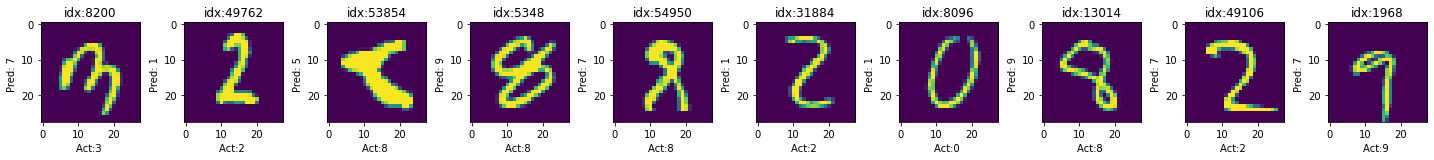

In [34]:
train_data = train.train_data
train_labels = train.train_labels
print_wrong_image(model,device,train_data,train_labels,10)

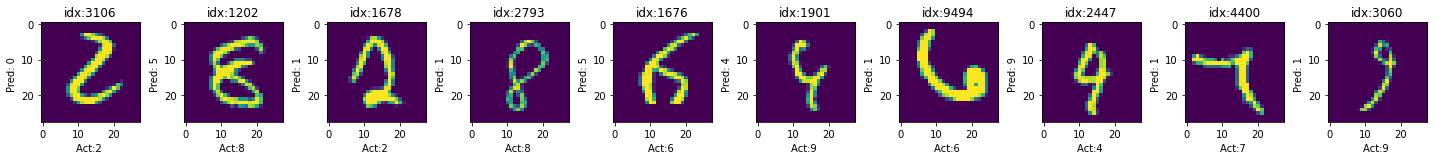

In [35]:
test_data = test.test_data
test_labels = test.test_labels
print_wrong_image(model,device,test_data,test_labels,10)

In [36]:
#Saving the most precious Meney by clearning some GPU space   
import torch, gc
gc.collect()
torch.cuda.empty_cache()

37839